In [59]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

probe_pixel_size = 1.25156e-6 # meters

Original shape:  (800, 800)
Cropped shape:  (160, 160)


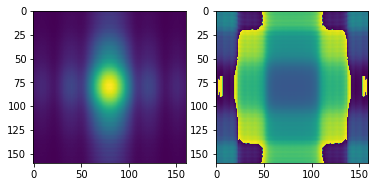

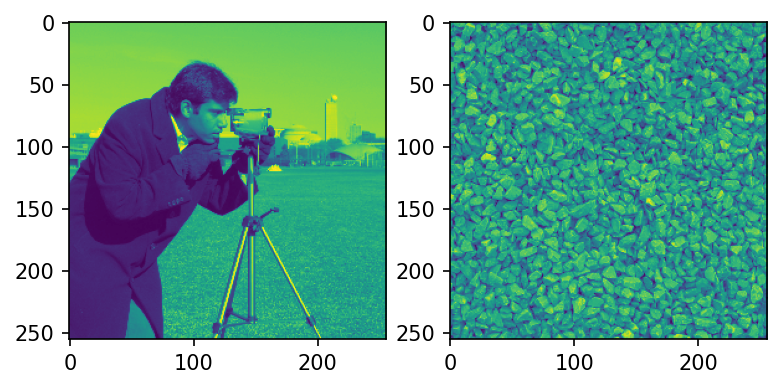

In [119]:
def get_simulated_data(model_object,probe, probe_steps_xy,random_positions=True,use_bad_points=False, add_position_errors=False,object_offset = 50):

    """ Create Probe """
    dimension = probe.shape[0]

    positionsX,positionsY = get_positions_array(probe_steps_xy,probe.shape,random_positions)

    model_object = set_object_frame(positionsY, positionsX,model_object,probe,object_offset,'',save=False)

    difpads = []
    for px,py in zip(positionsX,positionsY):
    
        """ Exit wave-field """
        W = model_object[py:py+dimension,px:px+dimension]*probe
    
        """ Propagation """
        difpad = np.fft.fft2(W)
        difpad = np.fft.fftshift(difpad)
        
        """ Measurement """
        difpad = np.absolute(difpad)**2
    
        if use_bad_points:# add invalid grid to data
            difpad = apply_invalid_regions(difpad)
        
        difpads.append(difpad)

    positions = np.hstack((np.array([positionsX]).T ,np.array([positionsY]).T)) # adjust positions format for proper input
    difpads = np.asarray(difpads)
    
    print(f"DP: {difpads.shape}")
    print(f"Positions: {positions.shape}")
    print(f"Object: {model_object.shape}")
    print(f"Probe: {probe.shape}")
    
    if add_position_errors:
        max_error = 0.1*np.mean(positions)
        positions_errors = max_error*np.random.rand(*positions.shape)
        positions = positions + positions_errors
        return difpads, positions, model_object, probe, positions_errors
    else:
        positions_errors = []
        return difpads, positions, model_object, probe, positions_errors

def apply_random_shifts_to_positions(positionsX,positionsY,mu=0,sigma=3,type='gaussian'):
        if type == 'gaussian':
            deltaX = np.random.normal(mu, sigma, positionsX.shape)
            deltaY = np.random.normal(mu, sigma, positionsY.shape)
            # X, Y = np.round(positionsX+deltaX).astype(np.int),np.round(positionsY+deltaY).astype(np.int)
            # X -= np.min(X)
            # Y -= np.min(Y)
            # return X, Y
        elif type=='random':
            deltaX = np.round(sigma*np.random.rand(*positionsX.shape))
            deltaY = np.round(sigma*np.random.rand(*positionsY.shape))
            
        deltaX = np.round(deltaX).astype(int)
        deltaY = np.round(deltaY).astype(int)
        
        new_positions_x = positionsX+deltaX
        min_x = np.min(new_positions_x)
        new_positions_x -= min_x
        
        new_positions_y = positionsY+deltaY
        min_Y = np.min(new_positions_y)
        new_positions_y -= min_Y
        
        return new_positions_x, new_positions_y

    
def get_positions_array(probe_steps_xy,frame_shape,random_positions=True):

    dx, dy = probe_steps_xy # probe step size in each direction
    y_pxls = np.arange(0,frame_shape[0]+1,dy)
    x_pxls = np.arange(0,frame_shape[1]+1,dx)

    if random_positions == True:
        x_pxls,y_pxls = apply_random_shifts_to_positions(x_pxls,y_pxls)

    positionsY,positionsX = np.meshgrid(y_pxls,x_pxls)
    
    if 0: # Plot positions map
        figure, ax = plt.subplots(dpi=100)
        ax.plot(positionsX,positionsY,'x',label='Original')
        ax.set_title('Positions') 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_aspect('equal')
    
    return positionsX.flatten(),positionsY.flatten()

def set_object_frame(y_pxls, x_pxls,frame,probe,object_offset,path,save=True):
    obj = np.zeros(set_object_size_pxls(x_pxls,y_pxls,probe.shape,object_offset),dtype=complex)
    obj[object_offset:object_offset+frame.shape[0],object_offset:object_offset+frame.shape[1]] = frame

    if save:
        model_path = os.path.join(path,'model','model_obj.npy')
        np.save(model_path,obj)
        print(f"Calculating diffraction data for object of size {obj.shape}. Used {object_offset} pixel of offset at the border.")
        print(f"\tData saved at: ",model_path)
    return obj

def set_object_size_pxls(x_pos,y_pos,probe_size,border):
    shape = (int(probe_size[0]+(np.max(y_pos)-np.min(y_pos))),int(probe_size[1]+(np.max(x_pos)-np.min(x_pos))))
    return shape

probe = np.load('probe_at_focus_1.25156um_pixel.npy') # example of CATERETE probe provide by Sergio Lordano

print('Original shape: ', probe.shape)

# Crop
N = 320
probe = probe[N:-N,N:-N]
print('Cropped shape: ', probe.shape)

fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(probe))
ax[1].imshow(np.angle(probe))
np.save('probe.npy',probe)

image1 =  getattr(data, 'camera')()
camera = image1[0::2,0::2]


image2 = getattr(data, 'gravel')()
gravel = image2[0::2,0::2]
gravel = gravel/np.max(gravel)

obj = camera*np.exp(1j*gravel)


np.save('object.npy',obj)
# np.save('camera.npy',camera)
# np.save('gravel.npy',gravel)

fig, ax = plt.subplots(1,2,dpi=150)
ax[0].imshow(np.abs(obj))
ax[1].imshow(np.angle(obj))

In [120]:
probe_steps_xy = (20,20) # step size (pixels) in x and y directions
DPs, positions, obj, probe, positions_errors = get_simulated_data(obj,probe, probe_steps_xy,random_positions=True, add_position_errors=False,object_offset = 30)

np.save('data.npy',DPs)
np.save('positions.npy',positions)
np.save('processed_obj.npy',obj)

DP: (81, 160, 160)
Positions: (81, 2)
Object: (315, 323)
Probe: (160, 160)


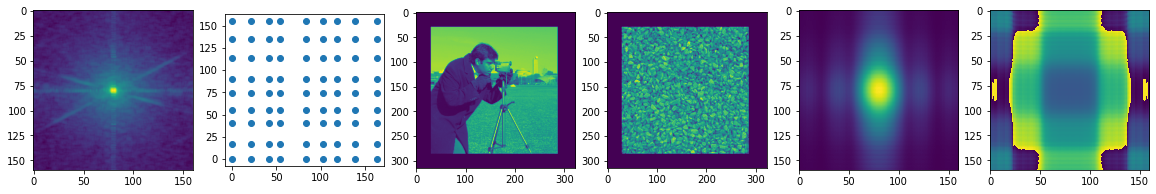

In [121]:
fig, ax = plt.subplots(1,6,figsize=(20,6))
ax[0].imshow(DPs.mean(0),norm=LogNorm())
ax[1].plot(positions[:,0],positions[:,1],'o')
ax[1].set_aspect('equal')
ax[2].imshow(np.abs(obj))
ax[3].imshow(np.angle(obj))
ax[4].imshow(np.abs(probe))
ax[5].imshow(np.angle(probe))